# LSTM + GloVe + Cross-validation + LearningRate changes + ...

from [ivan's](https://www.kaggle.com/demesgal/lstm-glove-lr-decrease-bn-cv-lb-0-047) attempt

In [36]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
print('hi')



hi


In [37]:
path = '../data/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE='../data/glove6b100d/glove.6B.100d.txt'
#EMBEDDING_FILE='../data/glove6b50d/glove.6B.50d.txt'

TRAIN_DATA_FILE='../data/train.csv'
TEST_DATA_FILE='../data/test.csv'



Set some basic config parameters:

In [38]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector) #532299
maxlen = 100 # max number of words in a comment to use #50



Read in our data and replace missing values:


In [39]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)


list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values



Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).


In [42]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
processed_X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
processed_X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)



Read the glove word vectors (space delimited strings) into a dictionary from word->vector.


In [43]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))



Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.


In [44]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.0044520046, 0.40815669)

In [45]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



ROC AUC for CV in Keras see for details: https://gist.github.com/smly/d29d079100f8d81b905e


In [46]:
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch, score))

### Valentin's Metric AUC ROC

To evaluate our model, we'll be looking at its AUC ROC score (area under the receiver operating characteristic curve). This is a fancy way to say we will be looking at the probability that our model ranks a randomly chosen positive instance higher than a randomly chosen negative one. With data that mostly consists of negative labels (no toxicity), our model could just learn to always predict negative and end up with a pretty high accuracy. AUC ROC helps correct this by putting more weight on the the positive examples.


In [24]:
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=10, max_epoch = 20):
        super(Callback, self).__init__()

        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            """Important lines"""
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite = True)
            print("--- AUC - epoch: {:d} - score: {:.5f}\n".format(epoch+1, current))



Bidirectional LSTM with half-size embedding with two fully connected layers


In [47]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
x = Bidirectional(LSTM(50, return_sequences=True,dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(50, activation="relu")(x)
#x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

import keras.backend as K
def loss(y_true, y_pred):
     return K.binary_crossentropy(y_true, y_pred)
    
model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])



Now we're ready to fit out model! Use validation_split when for hyperparams tuning


In [48]:
print('processed_X_train.shape')
print(processed_X_train.shape)
print('y')
print(y.shape)

X_t.shape
(159571, 100)
y
(159571, 6)


In [50]:
def schedule(ind):
    a = [0.002,0.003, 0.000]
    return a[ind]
lr = callbacks.LearningRateScheduler(schedule)
[X_train, X_val, y_train, y_val] = train_test_split(processed_X_train, y, train_size=0.95)

ra_val = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

graph = model.fit(X_train, y_train, batch_size=64, epochs=3, validation_data=(X_val, y_val), callbacks=[lr, ra_val])
#model.fit(X_t, y, batch_size=64, epochs=3, callbacks=[lr])

/home/mike/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 151592 samples, validate on 7979 samples
Epoch 1/3
151592/151592 [==============================] - 927s 6ms/step - loss: 0.0504 - acc: 0.9089 - val_loss: 0.0478 - val_acc: 0.9762

 ROC-AUC - epoch: 0 - score: 0.985065
Epoch 2/3
151592/151592 [==============================] - 963s 6ms/step - loss: 0.0444 - acc: 0.9390 - val_loss: 0.0489 - val_acc: 0.9875

 ROC-AUC - epoch: 1 - score: 0.984427
Epoch 3/3
151592/151592 [==============================] - 879s 6ms/step - loss: 0.0379 - acc: 0.9790 - val_loss: 0.0481 - val_acc: 0.9862

 ROC-AUC - epoch: 2 - score: 0.984182




And finally, get predictions for the test set and prepare a submission CSV:


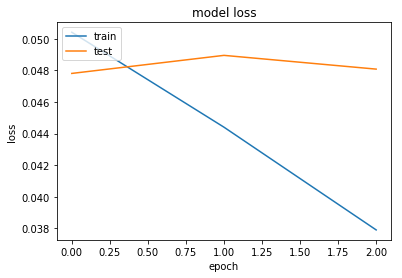

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

After training our model, we end up with an AUC ROC score of ???

* Add more layers.
* Experiment with different dropout and normalization techniques.
* Experiment with different layers and parameters.
* Experiment with cleaning the data more (translation, label adjustments, etc).

### Load best weights and predict

In [52]:
model.load_weights('./saved_models/model.best.hdf5')

OSError: Unable to open file (unable to open file: name = './saved_models/model.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [60]:
predictions = model.predict(processed_X_test, verbose=1)

153164/153164 [==============================] - 238s 2ms/step


### Format for Kaggle submission

In [61]:
sample_submission = pd.read_csv("../sample_submission.csv")
sample_submission[list_classes] = predictions
sample_submission.to_csv("../submission_revisedROC.csv", index=False)

### Create an App for prediction
Finally, let's build an app pipeline that can be put into production for toxic comment classification. It will take in a string and return the odds that it is any one of the toxic classifications.

In [62]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=100, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return



toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')
toxicity_level('fils de pub')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         97%
Severe Toxic:  13%
Obscene:       35%
Threat:        3%
Insult:        74%
Identity Hate: 3%

Toxicity levels for 'i will kill you':
Toxic:         95%
Severe Toxic:  7%
Obscene:       12%
Threat:        95%
Insult:        8%
Identity Hate: 4%

Toxicity levels for 'have a nice day':
Toxic:         25%
Severe Toxic:  0%
Obscene:       9%
Threat:        1%
Insult:        5%
Identity Hate: 1%

Toxicity levels for 'hola, como estas':
Toxic:         9%
Severe Toxic:  0%
Obscene:       3%
Threat:        2%
Insult:        1%
Identity Hate: 0%

Toxicity levels for 'hola mierda joder':
Toxic:         7%
Severe Toxic:  0%
Obscene:       3%
Threat:        1%
Insult:        1%
Identity Hate: 0%

Toxicity levels for 'fils de pub':
Toxic:         22%
Severe Toxic:  3%
Obscene:       8%
Threat:        18%
Insult:        3%
Identity Hate: 4%

